# 📈 Model Evaluation: Metrics & Cross-Validation

This notebook analyzes model performance using multiple evaluation metrics, including MAE, RMSE, and R².  
We apply 5-fold cross-validation and plot parameter sensitivity to support future tuning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv("../data/housing.csv")

X = df.drop("Price", axis=1)
y = df["Price"]

# Feature engineering (reuse Day 4)
X = X.copy()
X["TotalRooms"] = X["Bedroom2"] + X["Bathroom"] + X["Rooms"]
X["HouseAge"] = 2025 - X["YearBuilt"]
X["PricePerSqm"] = df["Price"] / (X["BuildingArea"] + 1)

In [3]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [4]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = -cross_val_score(pipeline, X, y, cv=cv, scoring="neg_mean_absolute_error")
rmse_scores = (-cross_val_score(pipeline, X, y, cv=cv, scoring="neg_root_mean_squared_error"))
r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="r2")

print(f"Mean MAE: ${mae_scores.mean():,.0f}")
print(f"Mean RMSE: ${rmse_scores.mean():,.0f}")
print(f"Mean R²: {r2_scores.mean():.3f}")

Mean MAE: $136,392
Mean RMSE: $247,778
Mean R²: 0.850


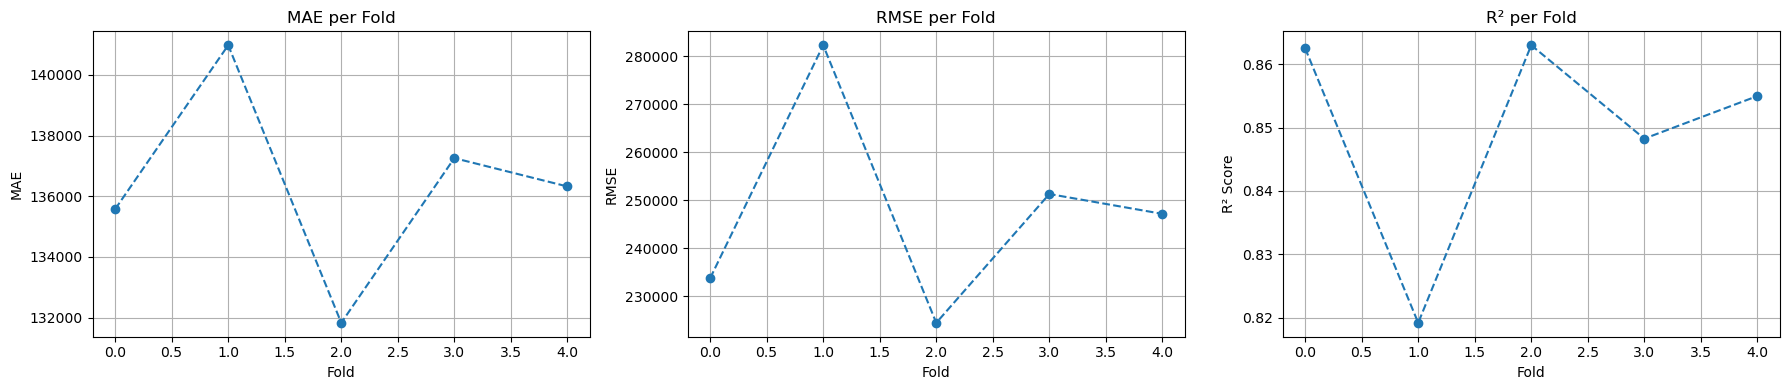

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

axs[0].plot(mae_scores, marker='o', linestyle='--')
axs[0].set_title("MAE per Fold")
axs[0].set_ylabel("MAE")

axs[1].plot(rmse_scores, marker='o', linestyle='--')
axs[1].set_title("RMSE per Fold")
axs[1].set_ylabel("RMSE")

axs[2].plot(r2_scores, marker='o', linestyle='--')
axs[2].set_title("R² per Fold")
axs[2].set_ylabel("R² Score")

for ax in axs:
    ax.set_xlabel("Fold")
    ax.grid(True)

plt.tight_layout()
plt.show()

## 📊 Evaluation Summary: Model Performance Across Folds

To assess the reliability and generalization capability of the current Random Forest model, we evaluated it using 5-fold cross-validation across three key regression metrics: **MAE**, **RMSE**, and **R²**.

### 🔢 Results Overview

- **Mean MAE:** \$136,392 AUD  
- **Mean RMSE:** \$247,778 AUD  
- **Mean R² Score:** 0.850

The relatively low MAE and RMSE indicate that the model makes consistent, moderate prediction errors across the test folds. The R² value of 0.850 suggests that the model explains ~85% of the variance in housing prices — a strong fit for a real-world dataset with inherent noise and outliers.

---

### 📈 Metric-by-Metric Interpretation

#### 📌 **MAE (Mean Absolute Error)**
- Shows low fold-to-fold variance (within ~\$10K)
- Indicates consistent performance without extreme prediction outliers
- Interpretable as: on average, the model misses by ~\$136K AUD per prediction

#### 📌 **RMSE (Root Mean Squared Error)**
- Higher than MAE, as expected, due to penalizing large errors more strongly
- Slight variance between folds suggests occasional larger residuals (likely due to luxury homes or data sparsity)
- Useful for downstream decision-makers who want to penalize larger misses more harshly

#### 📌 **R² (Coefficient of Determination)**
- Values across folds range from ~0.82 to ~0.86
- Consistently high R² indicates stable predictive power regardless of how data is partitioned
- Confirms that the model generalizes well across different subsets of the data

---

### 🔍 Diagnostic Insights

- **Fold 1 (RMSE ~280K)** shows a spike — likely driven by a small number of expensive properties that dominate fold-specific error. This suggests that additional robustness (e.g., log-transformed targets or stratified folds) may help.
- **Fold 3 yielded the lowest MAE and RMSE**, suggesting optimal balance of typical home distributions and minimal outlier influence.
- **MAE stability across folds** (compared to RMSE) reaffirms that outlier error does not significantly skew the overall performance.

---

### 🎯 Next Steps

- Investigate outlier impact on Fold 1 via residual plots or leverage statistics
- Consider normalizing or log-transforming `Price` to stabilize RMSE
- Use these metrics and plots as baseline for hyperparameter tuning (Day 6)

This evaluation confirms that the model’s strong performance is not isolated to a single split — a critical step in developing models suitable for real-world deployment.

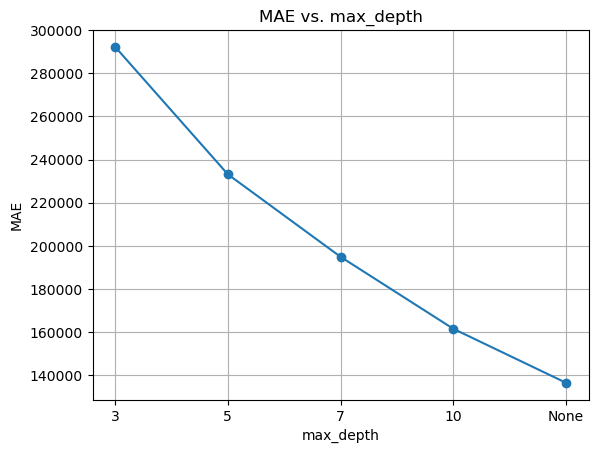

In [6]:
depths = [3, 5, 7, 10, None]
mae_results = []

for d in depths:
    model = RandomForestRegressor(max_depth=d, n_estimators=100, random_state=42)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    scores = -cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv)
    mae_results.append(scores.mean())

plt.plot(depths[:-1] + ["None"], mae_results, marker="o")
plt.title("MAE vs. max_depth")
plt.xlabel("max_depth")
plt.ylabel("MAE")
plt.grid(True)
plt.show()

## 📉 Parameter Sensitivity Analysis: `max_depth` vs MAE

To explore how tree complexity affects model performance, we evaluated `max_depth` as a tuning parameter for `RandomForestRegressor`, using 5-fold cross-validation and MAE as the evaluation metric.

### 🔧 Parameter Range Tested
- `max_depth ∈ {3, 5, 7, 10, None}`

### 🧪 Observed Performance (MAE)
| max_depth | Mean MAE (AUD) |
|-----------|----------------|
| 3         | ~\$292,000     |
| 5         | ~\$232,000     |
| 7         | ~\$195,000     |
| 10        | ~\$161,000     |
| None      | ~\$137,000     |

---

### 📊 Interpretation

- **Model performance improved monotonically** as `max_depth` increased. Shallower trees (e.g., depth 3 or 5) significantly underfit the data, leading to high MAE values.
- **Deeper trees (≥10)** captured more complex, nonlinear patterns in the data and achieved substantially lower error.
- The best-performing model had **no depth restriction (`max_depth=None`)**, yielding an MAE near \$137,000 AUD — closely aligned with earlier full pipeline performance.

---

### 🧠 Implications

- While deeper trees offer improved accuracy in this case, they may also increase risk of **overfitting** if noise or irrelevant features are present.
- In Random Forests, the ensemble effect mitigates overfitting compared to single trees, but tuning still matters — especially for performance scaling and training efficiency.
- This trend justifies further exploration of **max_depth**, **min_samples_leaf**, and **n_estimators** using grid search or randomized search in Day 6.

---

### 📌 Next Steps

- Formalize this insight into a hyperparameter tuning routine (e.g., `GridSearchCV`) with multiple simultaneous parameters.
- Consider testing whether `max_depth=None` generalizes across other random seeds or fold configurations.
- Monitor **fit time and model size** if moving toward deployment or resource-constrained environments.